# CIFAR-10 MLP 분류 실습

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juho127/ClassificationTest/blob/main/cifar10_mlp_tutorial.ipynb)

이 노트북에서는 CIFAR-10 데이터셋을 사용하여 다층 퍼셉트론(MLP)으로 이미지 분류를 수행합니다.

## 🚀 Google Colab에서 실행하는 경우
1. **런타임 > 런타임 유형 변경 > GPU** 선택 (학습 속도가 훨씬 빨라집니다!)
2. 셀을 순서대로 실행 (Shift + Enter)

## 목차
1. 라이브러리 임포트
2. 데이터셋 로드 및 탐색
3. MLP 모델 정의
4. 학습 및 평가
5. 결과 분석


## 0. 환경 설정 (Google Colab 전용)

**Colab에서 실행하는 경우**: 아래 셀을 실행하세요.  
**로컬에서 실행하는 경우**: 아래 셀을 건너뛰세요.


In [1]:
# Google Colab 환경 확인 및 설정
try:
    import google.colab
    IN_COLAB = True
    print("✓ Google Colab 환경에서 실행 중입니다.")
    print("📌 팁: 런타임 > 런타임 유형 변경 > GPU를 선택하면 더 빠릅니다!")
except:
    IN_COLAB = False
    print("✓ 로컬 환경에서 실행 중입니다.")

# Colab에서 필요한 경우 추가 패키지 설치
if IN_COLAB:
    print("\n필요한 패키지를 확인하는 중...")
    # Colab에는 대부분 설치되어 있지만, 확인차 실행
    import sys
    !{sys.executable} -m pip install -q torch torchvision tqdm matplotlib


✓ Google Colab 환경에서 실행 중입니다.
📌 팁: 런타임 > 런타임 유형 변경 > GPU를 선택하면 더 빠릅니다!

필요한 패키지를 확인하는 중...


## 1. 라이브러리 임포트


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
    print("🎉 GPU를 사용하여 빠르게 학습할 수 있습니다!")


PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True
GPU 이름: Tesla T4
🎉 GPU를 사용하여 빠르게 학습할 수 있습니다!


## 2. 데이터셋 로드 및 탐색


In [3]:
# 하이퍼파라미터 설정
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 10  # 노트북에서는 짧게 설정 (시간이 있다면 20으로 늘려보세요!)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 클래스 이름
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"사용 디바이스: {DEVICE}")
if DEVICE.type == 'cuda':
    print("✓ GPU를 사용합니다!")
else:
    print("ℹ CPU를 사용합니다. (Colab의 경우: 런타임 > 런타임 유형 변경 > GPU)")


사용 디바이스: cuda
✓ GPU를 사용합니다!


In [4]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Training samples: 50000
Test samples: 10000


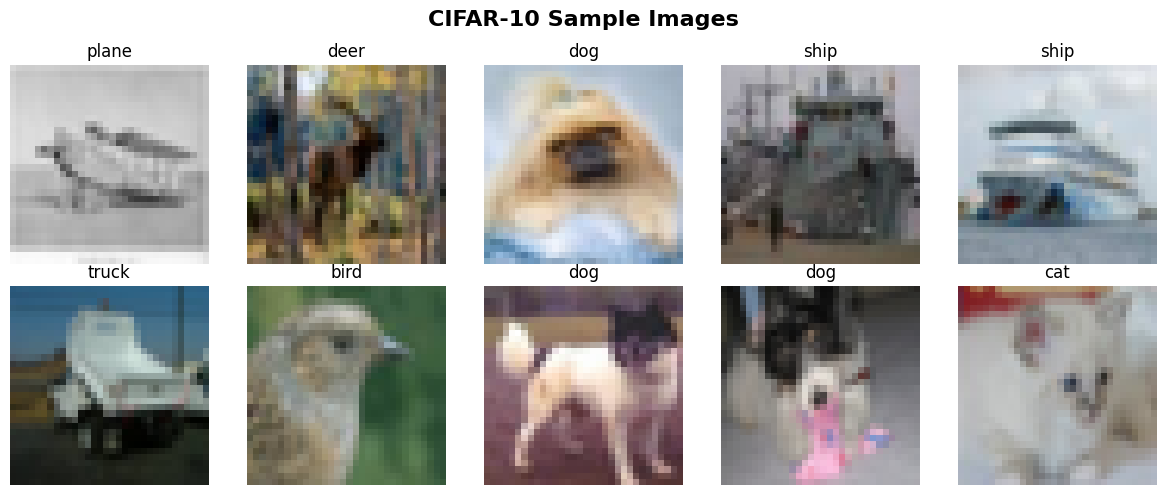

In [5]:
# Visualize sample images
def show_images(loader, num_images=10):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Denormalize
    images = images / 2 + 0.5

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('CIFAR-10 Sample Images', fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            img = images[idx].numpy().transpose((1, 2, 0))
            ax.imshow(img)
            ax.set_title(f'{CLASSES[labels[idx]]}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_loader)


## 3. MLP 모델 정의


In [6]:
class MLP(nn.Module):
    """다층 퍼셉트론 모델"""

    def __init__(self, input_size=3072, hidden_size1=512, hidden_size2=256, num_classes=10):
        super(MLP, self).__init__()

        # 첫 번째 은닉층
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        # 두 번째 은닉층
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        # 출력층
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        # 이미지를 1차원으로 펼치기 (32x32x3 = 3072)
        x = x.view(x.size(0), -1)

        # 첫 번째 은닉층
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # 두 번째 은닉층
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # 출력층
        x = self.fc3(x)
        return x

# 모델 생성
model = MLP().to(DEVICE)
print(model)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"\n전체 파라미터 수: {total_params:,}")


MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

전체 파라미터 수: 1,707,274


## 4. 학습 및 평가


In [7]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [8]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
    for images, labels in pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Evaluate function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / total
    test_acc = 100 * correct / total
    return test_loss, test_acc


In [9]:
# Start training
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Starting training!\n")

for epoch in range(NUM_EPOCHS):
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
    print("-" * 60)

print("\n학습 완료!")


Starting training!



Epoch 1/10: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s, loss=1.7330, acc=38.40%]



Epoch 1/10
  Train - Loss: 1.7330, Acc: 38.40%
  Test  - Loss: 1.5529, Acc: 45.63%
------------------------------------------------------------


Epoch 2/10: 100%|██████████| 391/391 [00:12<00:00, 31.24it/s, loss=1.5646, acc=44.69%]



Epoch 2/10
  Train - Loss: 1.5646, Acc: 44.69%
  Test  - Loss: 1.4471, Acc: 49.24%
------------------------------------------------------------


Epoch 3/10: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s, loss=1.4932, acc=47.23%]



Epoch 3/10
  Train - Loss: 1.4932, Acc: 47.23%
  Test  - Loss: 1.4341, Acc: 50.00%
------------------------------------------------------------


Epoch 4/10: 100%|██████████| 391/391 [00:11<00:00, 32.84it/s, loss=1.4449, acc=48.98%]



Epoch 4/10
  Train - Loss: 1.4449, Acc: 48.98%
  Test  - Loss: 1.4002, Acc: 50.27%
------------------------------------------------------------


Epoch 5/10: 100%|██████████| 391/391 [00:12<00:00, 32.37it/s, loss=1.4040, acc=50.53%]



Epoch 5/10
  Train - Loss: 1.4040, Acc: 50.53%
  Test  - Loss: 1.3873, Acc: 50.55%
------------------------------------------------------------


Epoch 6/10: 100%|██████████| 391/391 [00:12<00:00, 31.45it/s, loss=1.3629, acc=51.93%]



Epoch 6/10
  Train - Loss: 1.3629, Acc: 51.93%
  Test  - Loss: 1.3531, Acc: 52.01%
------------------------------------------------------------


Epoch 7/10: 100%|██████████| 391/391 [00:11<00:00, 33.23it/s, loss=1.3289, acc=53.11%]



Epoch 7/10
  Train - Loss: 1.3289, Acc: 53.11%
  Test  - Loss: 1.3508, Acc: 52.32%
------------------------------------------------------------


Epoch 8/10: 100%|██████████| 391/391 [00:11<00:00, 33.49it/s, loss=1.3048, acc=53.99%]



Epoch 8/10
  Train - Loss: 1.3048, Acc: 53.99%
  Test  - Loss: 1.3310, Acc: 53.34%
------------------------------------------------------------


Epoch 9/10: 100%|██████████| 391/391 [00:12<00:00, 30.85it/s, loss=1.2749, acc=54.62%]



Epoch 9/10
  Train - Loss: 1.2749, Acc: 54.62%
  Test  - Loss: 1.3240, Acc: 52.91%
------------------------------------------------------------


Epoch 10/10: 100%|██████████| 391/391 [00:12<00:00, 32.27it/s, loss=1.2465, acc=55.42%]



Epoch 10/10
  Train - Loss: 1.2465, Acc: 55.42%
  Test  - Loss: 1.3134, Acc: 53.95%
------------------------------------------------------------

학습 완료!


## 5. 결과 분석


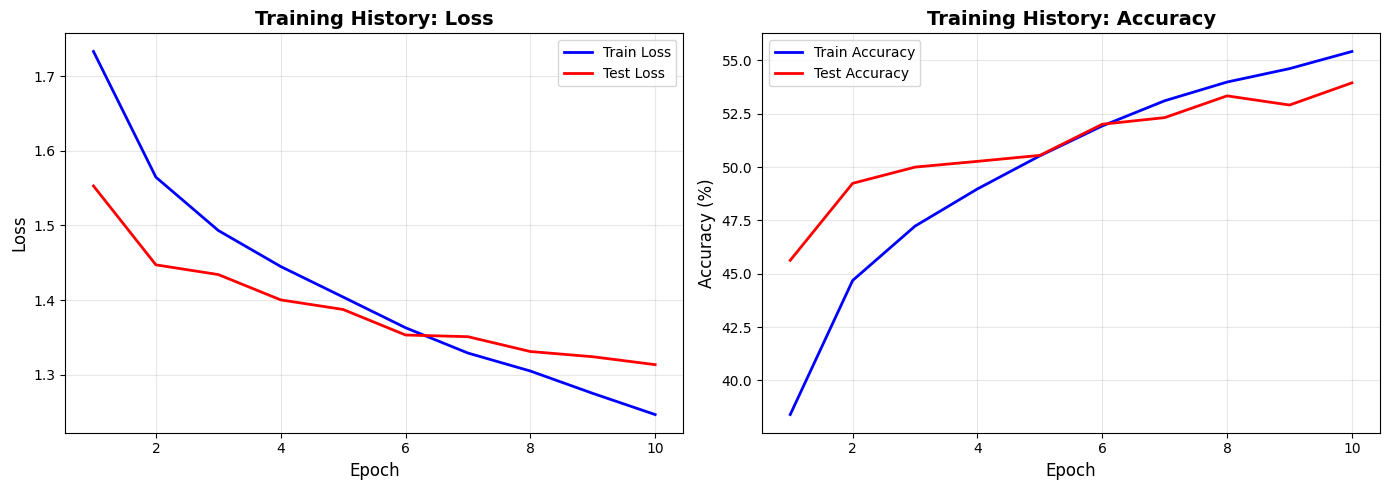

Final test accuracy: 53.95%


In [10]:
# Visualize training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_losses) + 1)

# Loss graph
ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training History: Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy graph
ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training History: Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final test accuracy: {test_accs[-1]:.2f}%")


In [11]:
# 클래스별 정확도 계산
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Per-class Accuracy:")
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f'  {CLASSES[i]:10s}: {acc:.2f}%')


Per-class Accuracy:
  plane     : 56.10%
  car       : 65.70%
  bird      : 35.20%
  cat       : 32.80%
  deer      : 45.00%
  dog       : 49.60%
  frog      : 60.00%
  horse     : 63.40%
  ship      : 71.80%
  truck     : 59.90%


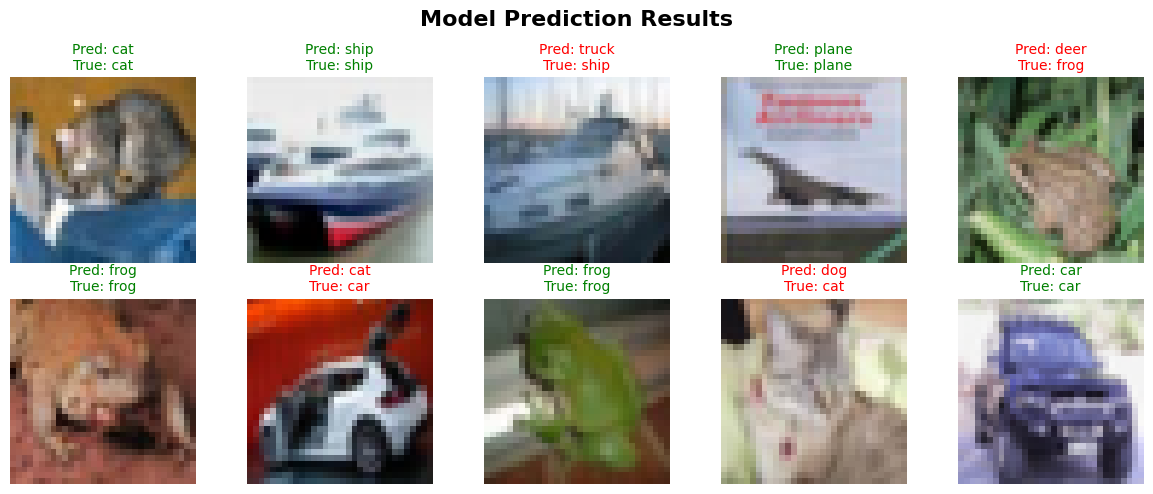

In [12]:
# Visualize prediction results
def visualize_predictions(model, loader, num_images=10):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images_display = images / 2 + 0.5  # Denormalize

    images = images.to(DEVICE)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('Model Prediction Results', fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            img = images_display[idx].numpy().transpose((1, 2, 0))
            ax.imshow(img)

            pred_label = CLASSES[predicted[idx]]
            true_label = CLASSES[labels[idx]]
            color = 'green' if predicted[idx] == labels[idx] else 'red'

            ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)


## 실습 과제

다음 내용을 실험해보세요:

1. **하이퍼파라미터 조정**
   - 학습률을 변경해보세요 (0.0001, 0.01 등)
   - 배치 크기를 변경해보세요 (64, 256 등)
   - 에포크 수를 늘려보세요

2. **모델 구조 변경**
   - 은닉층을 추가해보세요
   - 은닉층의 뉴런 수를 변경해보세요
   - Dropout 비율을 변경해보세요

3. **결과 분석**
   - 어떤 클래스가 분류하기 어려운가요?
   - 과적합(Overfitting)이 발생하나요?
   - MLP의 한계점은 무엇인가요?
